In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
from __future__ import annotations

import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_median
import numpyro_glm.utils.dist as dist_utils
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs
import pandas as pd
import seaborn as sns

numpyro.set_host_device_count(4)

# Chapter 12: Bayesian Approaches to Testing a Point ("Null") Hypothesis
## The Estimation Approach
### Region of Practical Equivalence

> A parameter value is declared to be not credible, or rejected,
if its entire ROPE lies outside of the 95% highest density interval (HDI)
of the posterior distribution of that parameter.

> A parameter value is declared to be accepted for practical purposes
if that value's ROPE completely contains the 95% HDI of the posterior
of that parameter.

## The Model Comparison Approach
### Are Different Groups Equal or Not?

Data are downloaded from [JWarmenhoven's implementation](https://github.com/JWarmenhoven/DBDA-python/blob/master/Notebooks/data/background_music.csv).

In [3]:
music_df: pd.DataFrame = pd.read_csv(
    'datasets/background_music.csv', dtype=dict(CondOfSubj='category'))
music_df['CondOfSubj'] = (music_df['CondOfSubj']
                          .cat.rename_categories(
                              {'1': 'Das Kruschke', '2': 'Mozart',
                               '3': 'Bach', '4': 'Beethoven'}))
music_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   CondOfSubj   80 non-null     category
 1   nTrlOfSubj   80 non-null     int64   
 2   nCorrOfSubj  80 non-null     int64   
dtypes: category(1), int64(2)
memory usage: 1.7 KB


In [4]:
# Wrong implementation, still don't understand why it gives wrong results?
def words_recall_in_different_music_genres_model_comparison(
        genre: jnp.ndarray, nb_trials: jnp.ndarray, nb_corrects: jnp.ndarray, nb_genres: int):
    assert genre.shape[0] == nb_trials.shape[0] == nb_corrects.shape[0]
    nb_obs = genre.shape[0]

    # We will compare between two models:
    # * Model 0 uses condition-specific omega,
    # * Model 1 uses the same omega for all conditions.
    model_probs = jnp.array([0.5, 0.5])
    model = numpyro.sample('model', dist.Categorical(model_probs))

    aP = 1.
    bP = 1.

    # Model 0's omegas.
    a = jnp.repeat(aP, nb_genres)
    b = jnp.repeat(bP, nb_genres)
    omega = numpyro.sample('omega', dist.Beta(a, b))

    # Model 1's omega1.
    a0 = aP
    b0 = bP
    # correspond to omega0 in the book.
    omega1 = numpyro.sample('omega1', dist.Beta(a0, b0))

    # Kappa's prior.
    kappa_minus_two = numpyro.sample(
        '_kappa-2', dist_utils.gammaDistFromModeStd(20, 20).expand([nb_genres]))
    kappa = numpyro.deterministic('kappa', kappa_minus_two + 2)

    ome = jnp.where(model == 0, omega, omega1)
    aBeta = ome * (kappa - 2) + 1
    bBeta = (1 - ome) * (kappa - 2) + 1

    # Observations.
    with numpyro.plate('obs', nb_obs) as idx:
        theta = numpyro.sample(
            'theta', dist.Beta(aBeta[genre[idx]], bBeta[genre[idx]]))
        numpyro.sample(
            'correct', dist.Binomial(nb_trials[idx], theta), obs=nb_corrects[idx])


# Correct implementation.
def words_recall_in_different_music_genres_model_comparison_1(
        genre: jnp.ndarray, nb_trials: jnp.ndarray, nb_corrects: jnp.ndarray, nb_genres: int):
    assert genre.shape[0] == nb_trials.shape[0] == nb_corrects.shape[0]
    nb_obs = genre.shape[0]

    # We will compare between two models:
    # * Model 0 uses condition-specific omega,
    # * Model 1 uses the same omega for all conditions.
    model_probs = jnp.array([0.5, 0.5])
    model = numpyro.sample('model', dist.Categorical(model_probs))

    aP = 1.
    bP = 1.

    # Model 0's omegas.
    a = jnp.c_[jnp.repeat(aP, nb_genres),
               [.40 * 125, .50 * 125, .51 * 125, .52 * 125]]
    b = jnp.c_[jnp.repeat(bP, nb_genres),
               [.60 * 125, .50 * 125, .49 * 125, .48 * 125]]
    omega = numpyro.sample('omega', dist.Beta(a[:, model], b[:, model]))

    # Model 1's omega1.
    a0 = jnp.array([.48 * 500, aP])
    b0 = jnp.array([.52 * 500, bP])
    # correspond to omega0 in the book.
    omega1 = numpyro.sample('omega1', dist.Beta(a0[model], b0[model]))

    # Kappa's prior.
    kappa_minus_two = numpyro.sample(
        '_kappa-2', dist_utils.gammaDistFromModeStd(20, 20).expand([nb_genres]))
    kappa = numpyro.deterministic('kappa', kappa_minus_two + 2)

    ome = jnp.where(model == 0, omega, omega1)
    aBeta = ome * (kappa - 2) + 1
    bBeta = (1 - ome) * (kappa - 2) + 1

    # Observations.
    with numpyro.plate('obs', nb_obs) as idx:
        theta = numpyro.sample(
            'theta', dist.Beta(aBeta[genre[idx]], bBeta[genre[idx]]))
        numpyro.sample(
            'correct', dist.Binomial(nb_trials[idx], theta), obs=nb_corrects[idx])


kernel = DiscreteHMCGibbs(
    NUTS(words_recall_in_different_music_genres_model_comparison_1,
         init_strategy=init_to_median))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    genre=jnp.array(music_df['CondOfSubj'].cat.codes.values),
    nb_trials=jnp.array(music_df['nTrlOfSubj'].values),
    nb_corrects=jnp.array(music_df['nCorrOfSubj'].values),
    nb_genres=music_df['CondOfSubj'].cat.categories.size,
)
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
_kappa-2[0]     49.46     22.28     45.84     15.53     82.41  27534.84      1.00
_kappa-2[1]     41.10     19.54     37.44     12.08     69.63  39607.31      1.00
_kappa-2[2]     49.33     21.84     45.74     16.29     81.48  44429.92      1.00
_kappa-2[3]     42.54     20.10     38.82     12.54     71.85  40444.59      1.00
      model      0.84      0.37      1.00      0.00      1.00   1113.00      1.00
   omega[0]      0.40      0.04      0.40      0.33      0.47 136459.60      1.00
   omega[1]      0.50      0.04      0.50      0.43      0.57 156858.82      1.00
   omega[2]      0.51      0.04      0.51      0.44      0.58 144526.92      1.00
   omega[3]      0.52      0.04      0.52      0.45      0.59 139961.23      1.00
     omega1      0.48      0.02      0.48      0.45      0.51  56254.38      1.00
   theta[0]      0.45      0.07      0.45      0.34      0.55  11024.65      1.00
   theta[1]    

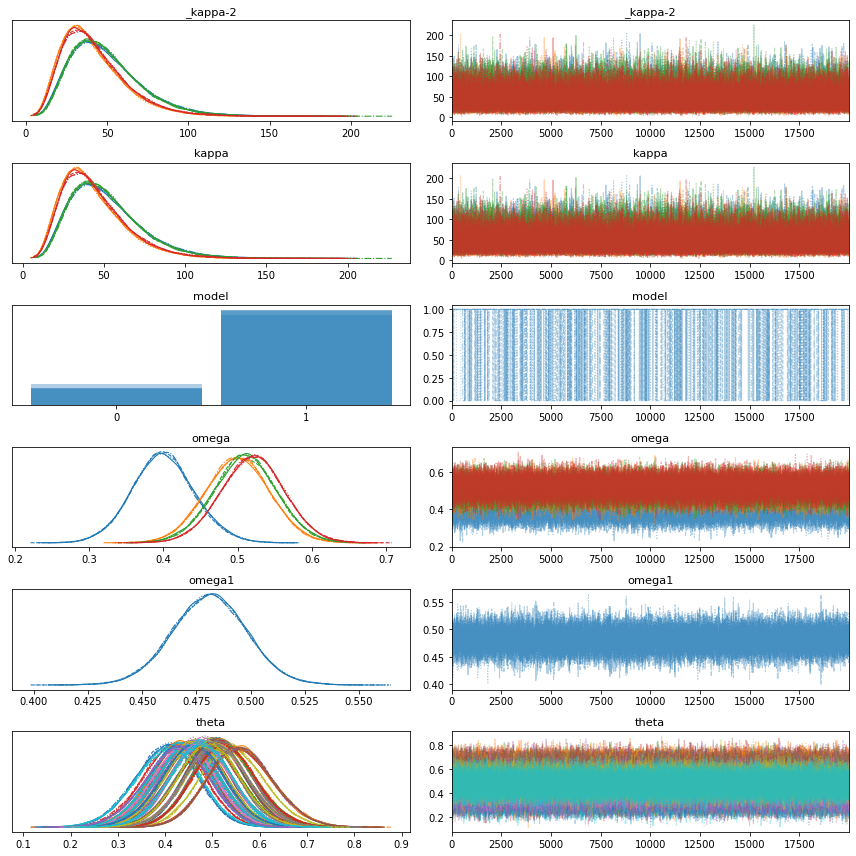

In [5]:
idata = az.from_numpyro(
    mcmc,
    coords=dict(genre=music_df['CondOfSubj'].cat.categories),
    dims=dict(omega=['genre'], kappa=['genre']))
az.plot_trace(idata)
plt.tight_layout()

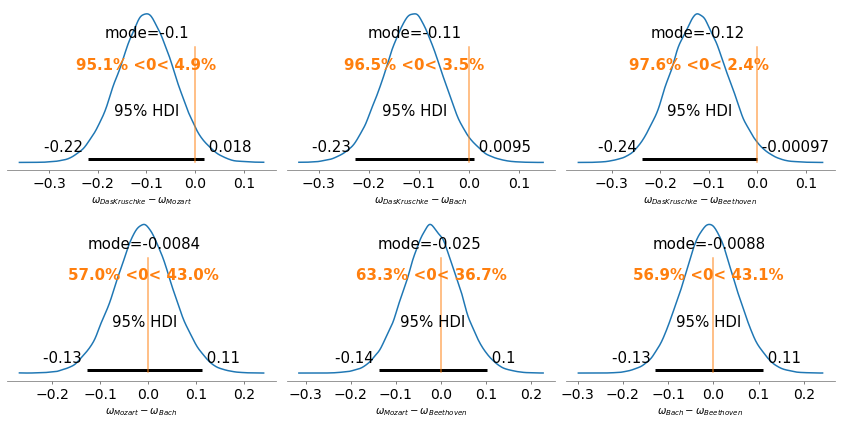

In [6]:
from itertools import combinations  # noqa

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
posterior = idata['posterior']

for (left, right), ax in zip(combinations(music_df['CondOfSubj'].cat.categories, 2),
                             axes.flatten()):
    left_omega = posterior['omega'].sel(genre=left).values
    right_omega = posterior['omega'].sel(genre=right).values

    diff = left_omega - right_omega
    az.plot_posterior(diff, hdi_prob=.95, ref_val=0.0,
                      point_estimate='mode', ax=ax)
    ax.set_title('')
    ax.set_xlabel(f'$\\omega_{{{left}}} - \\omega_{{{right}}}$')

fig.tight_layout()

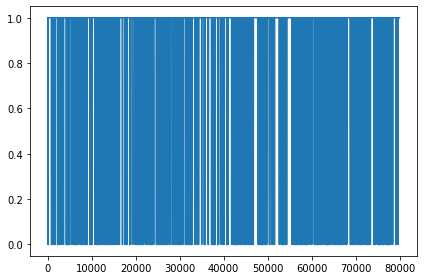

In [7]:
model_idx = posterior['model'].values.flatten()
sns.lineplot(x=np.indices(model_idx.shape).flatten(), y=model_idx)
plt.tight_layout()